In [194]:
%matplotlib inline

import numpy as np
import re
import string

from collections import Counter, defaultdict
from math import log
from nltk.corpus import stopwords
from operator import itemgetter

# Obtain data to classify

We will be using the 20 newsgroup dataset from sklear.datasets.

In [6]:
from sklearn.datasets import fetch_20newsgroups

categories = ['sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space']

newsgroups_train = fetch_20newsgroups(categories=categories, shuffle=True, random_state=12)  # available subset are: train, test, all (default: train)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=12)

# Our own Naive Bayes implementation

- Count number of documents per class
- Get vocabulary for each class
- Get count for each word in vocabulary
- Compute : (θjc= njc+α−1 / nc +α+β−2) and (θc = nc / n) where njc is the number of documents of class c containing the jth word, nc is the number of documents of class c, n is the total number of documents, and the user-selected hyperparameters α and β are pseudocounts that “smooth” the parameter estimates

In [7]:
newsgroups_train.keys()

dict_keys(['description', 'DESCR', 'target', 'filenames', 'target_names', 'data'])

In [58]:
total_articles = 0
articles_counter = Counter(newsgroups_train.target)
for key, count in articles_counter.items():
    print('{:15} : {}'.format(newsgroups_train.target_names[key], count))
    total_articles += count
print('{:15} : {}'.format('total_articles', total_articles))

sci.crypt       : 595
sci.electronics : 591
sci.med         : 594
sci.space       : 593
total_articles  : 2373


In [9]:
def separate_by_class(data_vector, target_vector):
    articles_by_class = defaultdict(list)
    for article, target_class in zip(data_vector, target_vector):
        articles_by_class[target_class].append(article)
    return articles_by_class
        
articles_by_class = separate_by_class(newsgroups_train.data, newsgroups_train.target)

In [52]:
regex = re.compile('[%s]' % re.escape(string.punctuation))

def vocabulary_by_class(articles_by_class, min_df, stopwords='english'):
    vocabulary_by_class = defaultdict(list)
    for article_class, articles in articles_by_class.items():
        for article in articles:
            article = regex.sub(' ', article)  # removing pucntuation
            article_tokens = [x.lower() for x in article.split() if not x.isdigit()]  # lowercase everything and remove digits
            vocabulary_by_class[article_class].extend(article_tokens)
    count_voc_by_class =  {k: Counter(v) for k, v in vocabulary_by_class.items()}
    count_voc_by_class =  _clean(count_voc_by_class, min_df, stopwords)
    return count_voc_by_class

def _clean(count_voc_by_class, min_df, language='english'):
    '''Remove stop words, words appearing less than min_df times.'''
    stops = set(stopwords.words(language))
    cleaned_vocabulary = {}
    for article_class, counter_vocabulary in count_voc_by_class.items():
        cleaned_vocabulary[article_class] = {}
        for word, count in counter_vocabulary.items():
            if (word not in stops) and (count >= min_df):
                cleaned_vocabulary[article_class][word] = count
    return cleaned_vocabulary
                
min_df = 10
word_count_by_class = vocabulary_by_class(articles_by_class, min_df)
            

In [195]:
# word_count_by_class

In [114]:
def compute_nb(word, word_count_by_class, article_class, total_articles, alpha=2, beta=1):
    '''Compute : (θjc= njc+α−1 / nc +α+β−2) and (θc = nc / n) where njc is the number of documents of class c 
    containing the jth word, nc is the number of documents of class c, n is the total number of documents, and 
    the user-selected hyperparameters α and β are pseudocounts that “smooth” the parameter estimates.'''
    njc = word_count_by_class[article_class].get(word, 0)
    nc = articles_counter[article_class]
    theta_jc = (njc + alpha - 1) / (nc + alpha + beta - 2)
    theta_c = nc / total_articles
    return theta_jc, theta_c
    

Test:

In [115]:
word = 'boston'
alpha = 1
beta = 2

theta_j0, theta_0 = compute_nb(word, word_count_by_class, 0, total_articles, alpha, beta)
theta_jc, theta_c = compute_nb(word, word_count_by_class, 2, total_articles, alpha, beta)
print('{}\ntheta_jc: {}\ntheta_c: {}'.format(word.upper(), theta_jc, theta_c))

BOSTON
theta_jc: 0.047058823529411764
theta_c: 0.2503160556257901


Compute:

* log (py=c|x /py=0|x j) =∑w_jc * x_j+ w_0c 

where

* wjc=log (θ_jc * (1−θ_j0) / θ_j0* (1−θ_jc))
* w0c=∑_j log ((1−θ_jc) / (1−θ_j0)) + log (θc / θ0) 

In [ ]:
def predict(article, word_count_by_class, alpha=2, beta=1, preds=False):
    predictions = {}
    words = clean(article)
    sigma_wjc = 0
    for article_class in sorted(list(set(newsgroups_train.target))):
        for word in words:
            try:
                wjc = compute_wjc(word, word_count_by_class, article_class, total_articles, alpha, beta)
                sigma_wjc += wjc
            except ValueError:
                pass
        w0c = compute_w0c(words, word_count_by_class, article_class, total_articles, alpha, beta)
        prediction = sigma_wjc + w0c
        predictions[article_class] = prediction
    if preds:
        return predictions
    else:
        return max(predictions.items(),key=itemgetter(1))[0] 
        
def clean(article, language='english'):
    words = []
    article = regex.sub(' ', article)  # removing pucntuation
    article_tokens = [x.lower() for x in article.split() if not x.isdigit()] # removing digits
    stops = set(stopwords.words(language))
    for word in article_tokens:
        if word not in stops:
            words.append(word)
    return words

def compute_wjc(word, word_count_by_class, article_class, total_articles, alpha, beta):
    theta_jc, theta_c = compute_nb(word, word_count_by_class, article_class, total_articles, alpha, beta)
    theta_j0, theta_0 = compute_nb(word, word_count_by_class, 0, total_articles, alpha, beta)
    # print(word, theta_jc, theta_c, theta_j0, theta_0)
    wjc = log((theta_jc * (1 - theta_j0)) / (theta_j0 * ( 1 - theta_jc)))
    return wjc
    
def compute_w0c(words, word_count_by_class, article_class, total_articles, alpha, beta):
    sigma_j = 0
    for word in words:
        try:
            theta_jc, theta_c = compute_nb(word, word_count_by_class, article_class, total_articles, alpha, beta)
            theta_j0, theta_0 = compute_nb(word, word_count_by_class, 0, total_articles, alpha, beta)
            sigma_j += log ((1.0 - theta_jc) / ( 1.0 - theta_j0))
        except ValueError:
            pass
    w0c = sigma_j + log(theta_c / theta_0)
    return w0c
        
    

In [ ]:
def accuracy_score(targets, preds):
    correct = 0
    if len(targets) != len(preds):
        raise ValueError
    else:
        for target, pred in zip(targets, preds):
            if target == pred:
                correct += 1
    return correct / float(len(targets))
        

In [ ]:
predictions = []
targets = []

for index in range(0, len(newsgroups_test.data)):
    article = newsgroups_test.data[index]
    target = newsgroups_test.target[index]
    targets.append(target)
    prediction = predict(article, word_count_by_class)
    predictions.append(prediction)
    
accuracy_score = accuracy_score(targets, predictions)

print('Accuracy score: {}'.format(accuracy_score))

# Naive bayes using sklearn

In [164]:
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [10]:
newsgroups_train.target_names

['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']

In [11]:
Counter(newsgroups_train.target)

Counter({0: 595, 1: 591, 2: 594, 3: 593})

In [167]:
min_df = 1
count = CountVectorizer(stop_words='english', min_df=min_df)

In [168]:
train_counts = count.fit_transform(newsgroups_train.data).toarray()
train_vocabulary = count.vocabulary_

In [169]:
test_vectorizer = CountVectorizer(stop_words='english', vocabulary=train_vocabulary)
test_counts = test_vectorizer.fit_transform(newsgroups_test.data).toarray()

In [189]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    tick_marks = np.arange(len(newsgroups_test.target_names))
    plt.xticks(tick_marks, newsgroups_test.target_names, rotation=45)
    plt.yticks(tick_marks, newsgroups_test.target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Gaussian NB
The likelihood of the features is assumed to be Gaussian. Mean and variance are estimated using maximum likelyhood.

In [190]:
clf_gaussian = GaussianNB()
clf_gaussian.fit(train_counts, newsgroups_train.target)
accuracy_score(newsgroups_test.target, clf_gaussian.predict(test_counts))

0.85053831538948699

Confusion matrix, without normalization


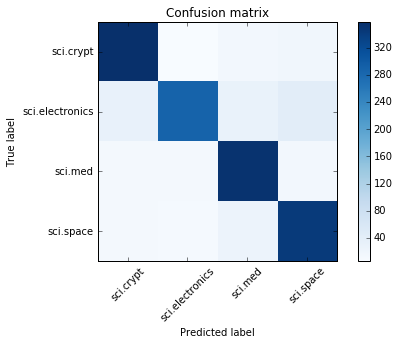

In [191]:
cm = confusion_matrix(newsgroups_test.target, clf_gaussian.predict(test_counts))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm)

### Multinomial NB

Algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).


In [171]:
clf_multinomial = MultinomialNB()
clf_multinomial.fit(train_counts, newsgroups_train.target)
accuracy_score(newsgroups_test.target, clf_multinomial.predict(test_counts))

0.94173527549081693

### Bernoulli NB

For data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. Therefore, this class requires samples to be represented as binary-valued feature vectors. 

It explicitly penalizes the non-occurrence of a feature i that is an indicator for class y, where the multinomial variant would simply ignore a non-occurring feature.
In the case of text classification, word occurrence vectors (rather than word count vectors) may be used to train and use this classifier. BernoulliNB might perform better on some datasets, especially those with shorter documents. It is advisable to evaluate both models, if time permits.

* Using count vectorizer

In [26]:
clf_bernoulli = BernoulliNB()
clf_bernoulli.fit(train_counts, newsgroups_train.target)
accuracy_score(newsgroups_test.target, clf_bernoulli.predict(test_counts))

0.77327422419252689

Confusion matrix, without normalization


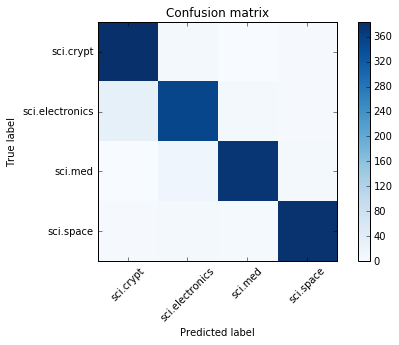

In [192]:
cm = confusion_matrix(newsgroups_test.target, clf_multinomial.predict(test_counts))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm)

* Using presence vectorizer (tfidf)

In [181]:
min_df = 1
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=min_df)
train_tfidf = tfidf_vectorizer.fit_transform(newsgroups_train.data).toarray()
test_tfidf = tfidf_vectorizer.transform(newsgroups_test.data).toarray()

In [182]:
clf_bernoulli = BernoulliNB()
clf_bernoulli.fit(train_tfidf, newsgroups_train.target)
accuracy_score(newsgroups_test.target, clf_bernoulli.predict(test_tfidf))

0.77327422419252689

Confusion matrix, without normalization


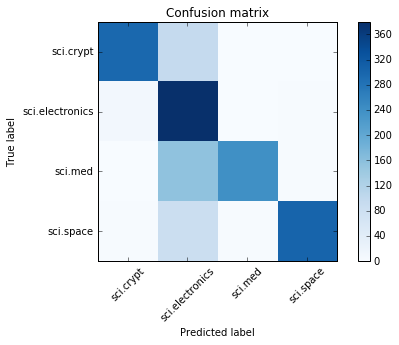

In [193]:
cm = confusion_matrix(newsgroups_test.target, clf_bernoulli.predict(test_counts))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm)